# Proyecto Sprint 12

## Descripción del proyecto

La empresa Zyfra desarrolla soluciones de eficiencia para la industria pesada.

Prepara un prototipo de un modelo de machine learning, el modelo debe predecir la cantidad de oro extraído del mineral de oro. El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.


### Objetivo:
- Preparar los datos para su análisis.
- Analizar los datos, su composición y distribución.
- Elige el mejor modelo y pruébalo utilizando la muestra de prueba.

Para comenzar con el analisis, tenemos que averiguar la estructura y tipo de datos de nuestras tablas de información.



In [ ]:
#Importamos todas las librerías necesarias para el proyecto

import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import median_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import (OrdinalEncoder ,StandardScaler)
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Cargamos los dataframes previamente realizados
'''
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
'''

df_full = pd.read_csv('/content/gold_recovery_full.csv')
df_test = pd.read_csv('/content/gold_recovery_test.csv')
df_train = pd.read_csv('/content/gold_recovery_train.csv')

In [ ]:
#Se realiza una introductoria visualización de los datos

df_gold = [df_full, df_test, df_train]

for df in df_gold:
    print('Data frame')
    df.info()
    print(df.head())
    print(df.describe())
    print(f'Existen {df.duplicated().sum()} duplicados')
    print(df.isna().sum())
    print()

Data frame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-nul

En general los datos estan bien estructurados, no hay duplicados ni pertenecen a otro tipo de dato, solo que hay bastantes valores ausentes y modificar la columna date a tipo time.

El dataframe de prueba no tiene los valores target que necesitaremos para comprobar nuesto modelo más adelante.

Las columnas del dataframe de prueba solo tiene valores de *input* o de *state* nada de los valores de *output*, esto por las predicciónes que tiene que hacer nuestro modelo con estas caracteristicas del proceso de recuperación de oro.

Antes de trabajar los datos tenemos que comprobar la columna de calculo de *rougher.output.recovery* que tenga los valores correctos.



In [ ]:
#Unimos los datos de target en el df_test con la columna date
df_test_mod = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')


In [ ]:
#Convertir de tipo object a datatime
dataframes = [df_full, df_test_mod, df_train]

for df in dataframes:
    df['date'] = pd.to_datetime(df['date'])

print(df_full.info())
print(df_test.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

In [ ]:
 #Columnas para el calculo y comporbacion de recovery

df_col=['rougher.output.concentrate_au',
        'final.output.concentrate_au',
        'rougher.input.feed_au',
        'rougher.output.tail_au',
        'final.output.tail_au',
        'rougher.output.recovery']

df_cal_recovery = df_train.loc[:, df_col]


#Funcion para el calculo de recovery
def cal_recovery(c, f, t):
  rec = ((c * (f - t)) / (f  * ( c - t)))  * 100
  return rec

def EAM(y,yi):
  return np.mean(np.abs(y-yi))


df_cal_recovery['cal_recovery'] = cal_recovery(df_cal_recovery['rougher.output.concentrate_au'],
                                               df_cal_recovery['rougher.input.feed_au'],
                                               df_cal_recovery['rougher.output.tail_au']
                                               )

df_cal_recovery['EAM'] = EAM(df_cal_recovery['rougher.output.recovery'], df_cal_recovery['cal_recovery'])

df_cal_recovery['son_iguales'] = ( np.isclose(df_cal_recovery['rougher.output.recovery'], df_cal_recovery['cal_recovery'], atol=1e-5)) | (df_cal_recovery['rougher.output.recovery'].isna() & df_cal_recovery['cal_recovery'].isna())

#Saber cuantas filas son iguales al calculo
print(df_cal_recovery['son_iguales'].value_counts())

#Filas que no son iguales
filas_false = df_cal_recovery[df_cal_recovery['son_iguales'] == False]
print(filas_false)

#Error aritmetico medio
print(df_cal_recovery['EAM'].mean())


son_iguales
True     16570
False      290
Name: count, dtype: int64
       rougher.output.concentrate_au  final.output.concentrate_au  \
53                          3.507147                    42.922611   
372                         4.642559                     4.304974   
377                        15.084039                    36.597453   
560                        19.619751                    45.273819   
700                         1.483835                    22.925720   
...                              ...                          ...   
16697                       6.038533                    46.249962   
16698                      10.712677                    46.803491   
16699                       0.010000                    48.654627   
16700                       0.010000                    49.429785   
16701                       0.031533                    49.602848   

       rougher.input.feed_au  rougher.output.tail_au  final.output.tail_au  \
53                  7.548

Realizando la comprobación podemos notar que el calculo es correcto,pusto que el EAM es bastante bajo osea que no hay diferencia, pero con los valores ausentes de las diferentes columnas algunos quedaron vacios, otros contienen 0 asi que el calculo no se puede dar, y otros tienen concentraciones bajas y eso cambia mucho el resultado.


In [ ]:
#Procederemos a llenar los valores ausentes con el método de imputación con K-Vecinos Más Cercanos (KNN).

col_de_train = list(df_test_mod.columns)

df_train_filtered = df_train[col_de_train]

for df in [df_train_filtered, df_test_mod]:
    if 'date' in df.columns:
        df.drop('date', axis=1, inplace=True)

dataframes = [df_test_mod, df_train_filtered]
results = []

for i, df in enumerate(dataframes):
    # Mismo pipeline para ambos (solo imputación)
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=3, weights='distance'))
    ])

    # Ajustar y transformar
    imputed_data = pipeline.fit_transform(df)

    df_imputed = pd.DataFrame(imputed_data,
                             columns=df.columns,
                             index=df.index)

    # Eliminar duplicados
    df_imputed.drop_duplicates(inplace=True)

    results.append(df_imputed)
    print(f'DataFrame {i} procesado: {"Train" if i == 1 else "Test"}')

# Resultados
df_test_imputed, df_train_imputed = results

DataFrame 0 procesado: Test
DataFrame 1 procesado: Train


In [ ]:
df_gold = [df_test_imputed, df_train_imputed]

for df in df_gold:
    print('Data frame')
    df.info()
    print(df.head())
    print(df.describe())
    print(f'Existen {df.duplicated().sum()} duplicados')
    print(df.isna().sum())
    print()

Data frame
<class 'pandas.core.frame.DataFrame'>
Index: 5850 entries, 0 to 5855
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5850 non-null   float64
 1   primary_cleaner.input.depressant            5850 non-null   float64
 2   primary_cleaner.input.feed_size             5850 non-null   float64
 3   primary_cleaner.input.xanthate              5850 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5850 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5850 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5850 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5850 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5850 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5850 non-null   float64
 10  primar

Se llenaron lo valores ausentes de manera correca, el tipo de dato de *date* fue modificado, llenamos los targets de df_test, y comprobamos que el calculo de la recuperacion fuera correcto.

Procederemos a un analisis de los datos, para saber su distribucion de manera más grafica.


/tmp/ipython-input-8-2730624750.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


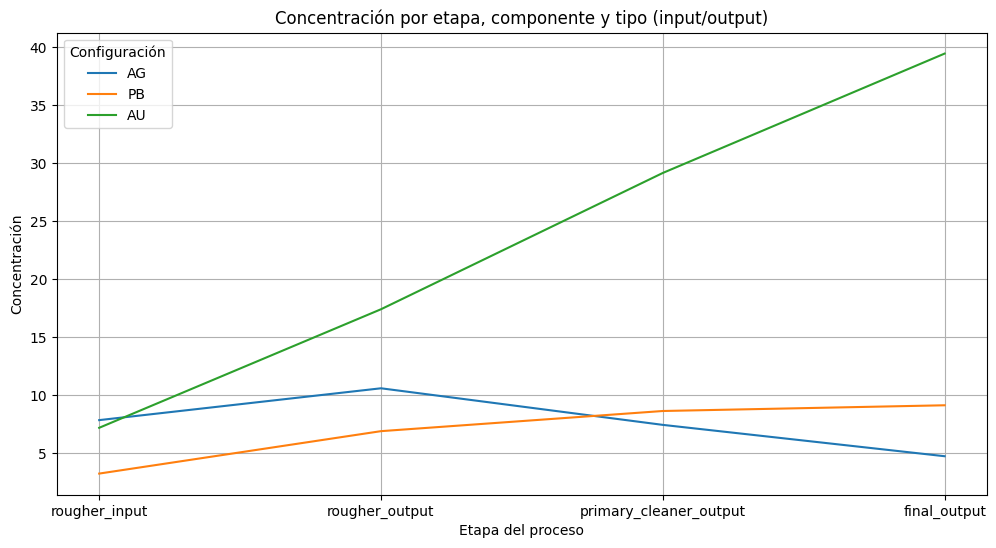

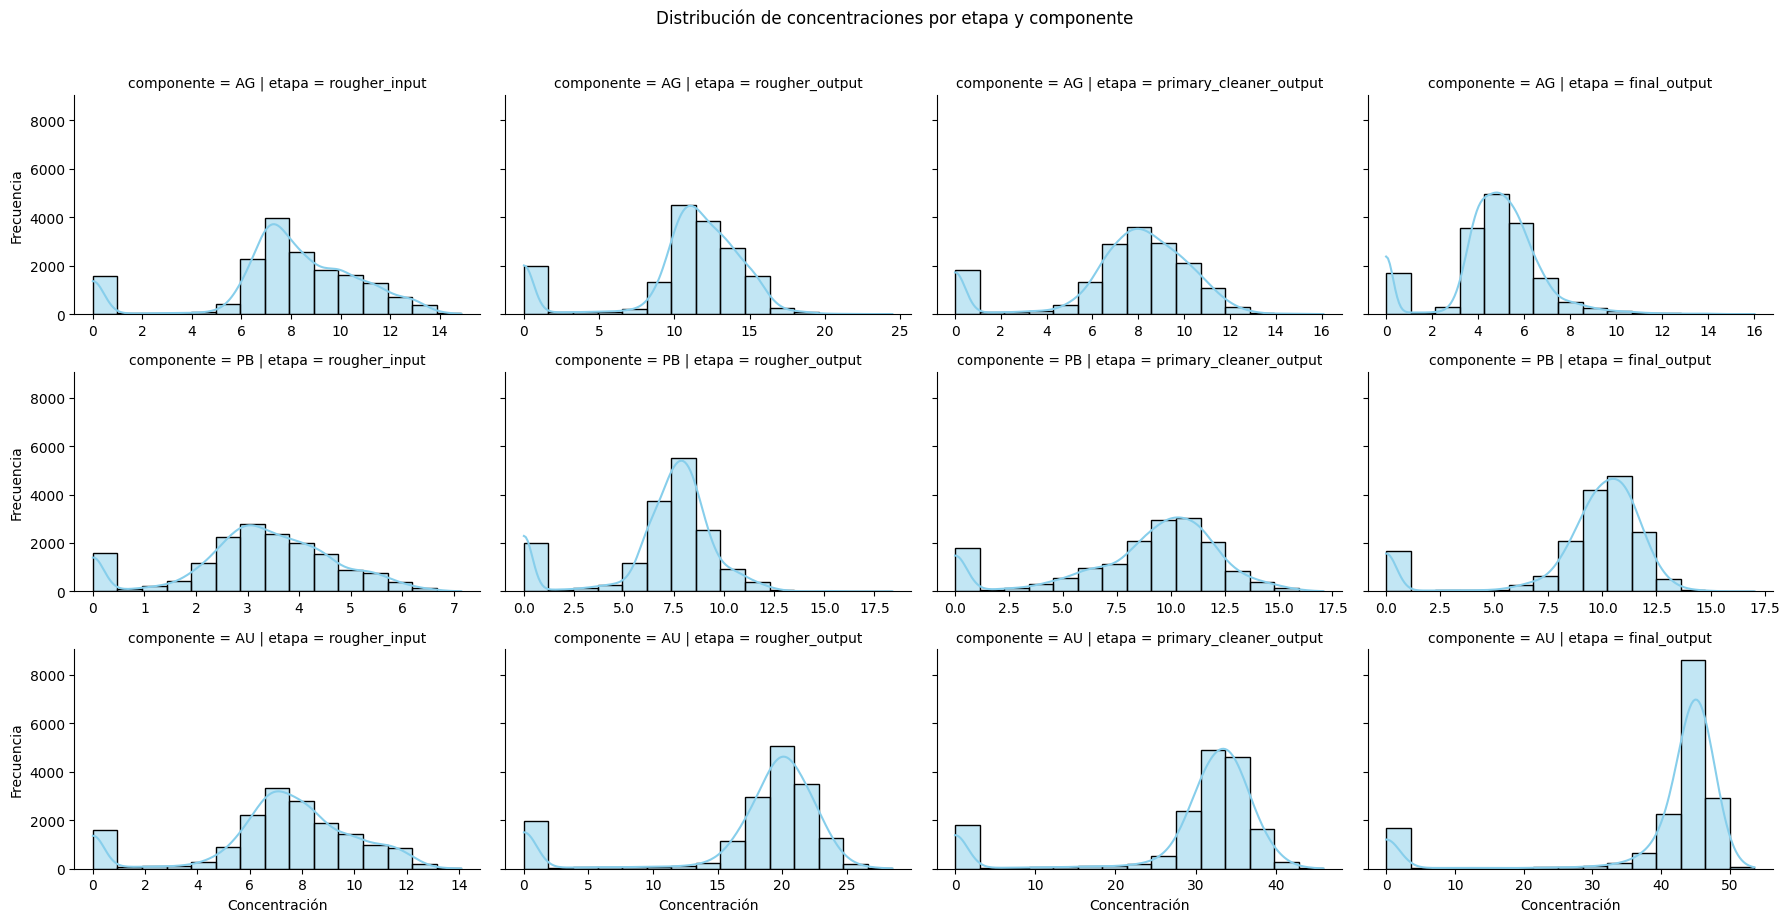

In [ ]:
#columnas de la concentracion en las diferentes etapas
columnas=[
'rougher.input.feed_ag',
'rougher.input.feed_pb',
'rougher.input.feed_au' ,
'rougher.output.concentrate_ag',
'rougher.output.concentrate_pb',
'rougher.output.concentrate_au',
'primary_cleaner.output.concentrate_au',
'primary_cleaner.output.concentrate_ag',
'primary_cleaner.output.concentrate_pb',
'final.output.concentrate_ag',
'final.output.concentrate_pb',
'final.output.concentrate_au']

df_etapas = df_train.loc[:, columnas]

df_long = pd.DataFrame()


for col in df_etapas.columns:
    # Dividir el nombre de la columna en partes
    parts = col.split('.')
    etapa = parts[0]
    tipo = parts[1]
    componente = parts[2].split('_')[-1].upper()
    etapa_tipo = f"{etapa}_{tipo}"

    # Crear un DataFrame temporal para esta columna
    temp_df = pd.DataFrame({
        'etapa': etapa_tipo,
        'componente': componente,
        'concentracion': df_etapas[col]
    })

    # Concatenar al DataFrame final
    df_long = pd.concat([df_long, temp_df], ignore_index=True)

#Gráfico de lineas de concentraciones por etapa por componente
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_long,
    x='etapa',
    y='concentracion',
    hue='componente',

    markers=True,
    ci=None
)
plt.title("Concentración por etapa, componente y tipo (input/output)")
plt.xlabel("Etapa del proceso")
plt.ylabel("Concentración")
plt.grid(True)
plt.legend(title='Configuración')
plt.show()

#Histograma de concentraciones por etapa y por componente
g = sns.FacetGrid(
    data=df_long,
    row='componente',
    col='etapa',
    sharex=False,
    height=3,
    aspect=1.5        )

g.map(sns.histplot, 'concentracion', kde=True, bins=15, color='skyblue')
g.set_axis_labels("Concentración", "Frecuencia")
g.fig.suptitle("Distribución de concentraciones por etapa y componente", y=1.02)
plt.tight_layout()
plt.show()


Enel gráfico de lineas (que toma el promedio por etapa), podemos decir que el oro es el principal metal para extraer, y se extrae con una considerable cantidad de plata, y el plomo es lo que más tratamos de limpiar con este proceso.

En los gráficos de distribución podemos notar que la mayoría de las distribuciones son normales y que todas tienen una cantidad considerable de datos en 0, es un pico bastante anormal, por lo que tendriamos que eliminarlo para que no tenga repercuciones en nuestro modelo.

Necesitamos revisar las distribuciónes de los datos que tomaremos en el modelo para conocer si sus distribuciones son parecidas, así el modelo tendra una mejor predicción.


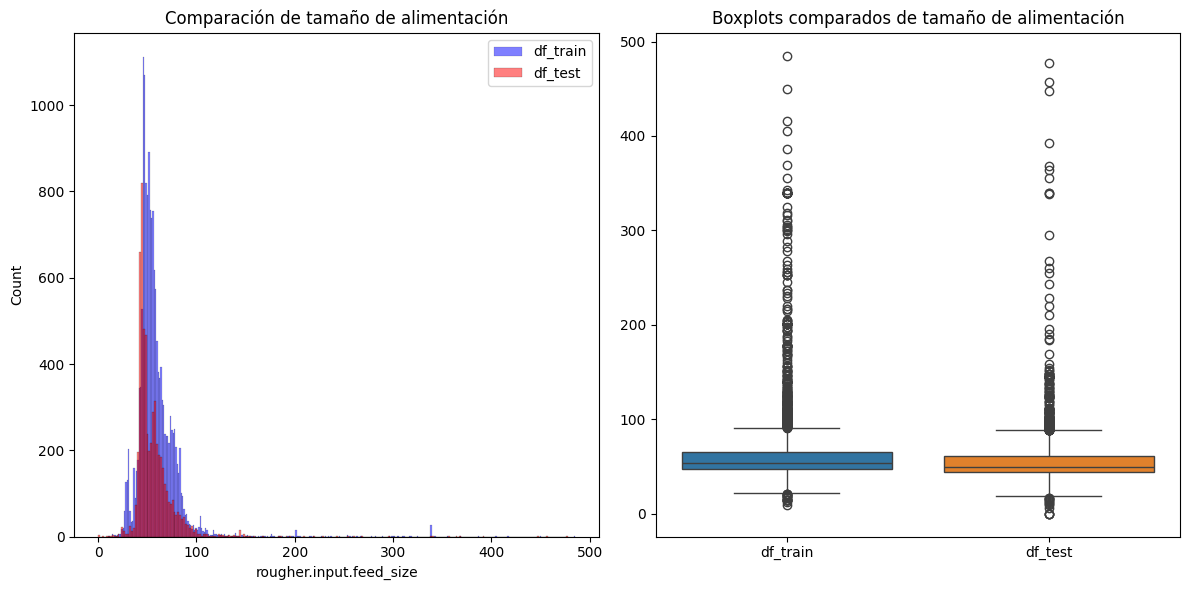

In [ ]:

df_train_feed = df_train.loc[:, ['rougher.input.feed_size']]
df_test_feed = df_test.loc[:, ['rougher.input.feed_size']]

plt.figure(figsize=(12, 6))

# Histogramas superpuestos
plt.subplot(1, 2, 1)
sns.histplot(df_train_feed['rougher.input.feed_size'], color='blue', alpha=0.5, label='df_train')
sns.histplot(df_test_feed['rougher.input.feed_size'], color='red', alpha=0.5, label='df_test')
plt.legend()
plt.title('Comparación de tamaño de alimentación')

# Boxplots lado a lado
plt.subplot(1, 2, 2)
sns.boxplot(data=pd.DataFrame({
    'df_train': df_train_feed['rougher.input.feed_size'],
    'df_test': df_test_feed['rougher.input.feed_size']
}))
plt.title('Boxplots comparados de tamaño de alimentación')

plt.tight_layout()
plt.show()

Aunque los datos en general del dataframe de entrenamiento son más grandes, si cumplen con la distribución parecida, teniendo los mismos picos y concentraciones de datos.

Ya con los datos imputados y escalados podemos comenzar a crear nuestro modelo de predicción, pero antes realizaremos una función que nos servira para realizar nuestras evaluaciones del modelo.

In [ ]:
# Definición de la métrica SMAPE (evita divisiones entre 0)
def smape_single(y_true, y_pred):

    with np.errstate(divide='ignore', invalid='ignore'):
        numerator = np.abs(y_true - y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred))
        smape = np.where(denominator == 0, 0, numerator / denominator) * 200
        return np.nanmean(smape)

# Funcíon para ambos SMAPE
def final_smape(y_true, y_pred):
    # Calcular SMAPE para cada target
    smape_rougher = smape_single(y_true[:, 0], y_pred[:, 0])
    smape_final = smape_single(y_true[:, 1], y_pred[:, 1])

    return 0.25 * smape_rougher + 0.75 * smape_final

# Convertir en scorer para scikit-learn (lower is better)
smape_scorer = make_scorer(final_smape, greater_is_better=False)

# Separar características y objetivos

X_train = df_train_imputed.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train = df_train_imputed[['rougher.output.recovery', 'final.output.recovery']]

X_test = df_test_imputed.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_test = df_test_imputed[['rougher.output.recovery', 'final.output.recovery']]


#Escalamos los datos para la predicción del modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Despues de realizar las funciones necesarias y dividir nuestros datos en train y target entrenaremos varios modelos para saber cual es el mejor para nuestros datos.

In [ ]:
# Crear modelo lineal
model = MultiOutputRegressor(LinearRegression())

# Validación cruzada
cv_results = cross_validate(model, X_train.values, y_train.values,
                              cv=5, scoring=smape_scorer,
                              return_train_score=True)

test_scores = -cv_results['test_score']
train_scores = -cv_results['train_score']

print("\nResultados:")
print("Test SMAPE::", np.mean(test_scores))
print("Train SMAPE::", np.mean(train_scores))



Resultados:
Test SMAPE:: 13.635464125622246
Train SMAPE:: 11.421840631233904


In [ ]:
#Entrenar modelo RandomForestRegressor para evitar errores
try:
    # Configuración segura del modelo
    rf_model = MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1  # Usa todos los núcleos del CPU
        ),
        n_jobs=-1
    )

    # Validación cruzada con manejo de errores
    rf_cv = cross_validate(rf_model, X_train.values, y_train.values,
                         cv=3, scoring=smape_scorer,
                         return_train_score=True,
                         error_score='raise')  # Forzamos a mostrar errores

    print("\nRandom Forest:")
    print(f"Test SMAPE: {-rf_cv['test_score'].mean():.2f}")
    print(f"Train SMAPE: {-rf_cv['train_score'].mean():.2f}")

except Exception as e:
    print(f"\nError en Random Forest: {str(e)}")
    print("Posibles soluciones:")
    print("- Verificar que X_train y y_train no contengan NaN/inf")
    print("- Reducir n_estimators si hay problemas de memoria")
    print("- Probar con max_depth más bajo")


Random Forest:
Test SMAPE: 14.51
Train SMAPE: 7.91


In [ ]:
#Entrenar modelo XGBRegressor para evitar errores
try:
    # Configuración óptima inicial
    xgb_model = MultiOutputRegressor(
        XGBRegressor(
            objective='reg:squarederror',
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            tree_method='hist'  # Más eficiente en memoria
        ),
        n_jobs=-1
    )

    # Convertir datos a formato óptimo para XGBoost
    if isinstance(X_train, pd.DataFrame):
        X_train_xgb = X_train.values
        y_train_xgb = y_train.values
    else:
        X_train_xgb = X_train
        y_train_xgb = y_train

    xgb_cv = cross_validate(xgb_model, X_train_xgb, y_train_xgb,
                          cv=5, scoring=smape_scorer,
                          return_train_score=True)

    print("\nXGBoost:")
    print(f"Test SMAPE: {-xgb_cv['test_score'].mean():.2f}")
    print(f"Train SMAPE: {-xgb_cv['train_score'].mean():.2f}")

except Exception as e:
    print(f"\nError en XGBoost: {str(e)}")
    print("Soluciones comunes:")
    print("1. Instalar XGBoost: pip install xgboost")
    print("2. Reducir n_estimators a 100 si hay problemas")
    print("3. Verificar tipos de datos: X_train debe ser float32/64")



XGBoost:
Test SMAPE: 12.37
Train SMAPE: 7.07


De los modelos entrenados el que mejor puntaje obtuvo fue el XGBRegressor, ahora usaremos nuestro data set de prueba.

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'estimator__n_estimators': randint(100, 1000),
    'estimator__max_depth': randint(2, 10),
    'estimator__learning_rate': uniform(0.01, 0.3),
    'estimator__subsample': uniform(0.6, 0.4),  # Entre 0.6 y 1.0
    'estimator__colsample_bytree': uniform(0.6, 0.4),
    'estimator__gamma': uniform(0, 0.5),
    'estimator__reg_alpha': uniform(0, 1),
    'estimator__reg_lambda': uniform(0, 1),
    'estimator__min_child_weight': randint(1, 10)
}

# Crear el modelo base
xgb_base = MultiOutputRegressor(
    XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist',
        n_jobs=1  # Importante para evitar conflictos con RandomizedSearchCV
    ),
    n_jobs=-1
)

# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10,  # Número de combinaciones a probar
    cv=3,
    scoring=smape_scorer,
    verbose=3,
    random_state=42,
    n_jobs=1  # Usar 1 para evitar problemas
)

# Asegurar que los datos están en el formato correcto
if isinstance(X_train, pd.DataFrame):
    X_train_xgb = X_train.values
    y_train_xgb = y_train.values
else:
    X_train_xgb = X_train
    y_train_xgb = y_train

# Ejecutar la búsqueda
random_search.fit(X_train_xgb, y_train_xgb)

# Mostrar los mejores parámetros
print("\nMejores parámetros encontrados:")
print(random_search.best_params_)

# Evaluar el mejor modelo
best_xgb = random_search.best_estimator_

xgb_cv = cross_validate(best_xgb, X_train_xgb, y_train_xgb,
                      cv=5, scoring=smape_scorer,
                      return_train_score=True)



print("\nMejor XGBoost:")
print(f"Test SMAPE: {-xgb_cv['test_score'].mean():.2f}")
print(f"Train SMAPE: {-xgb_cv['train_score'].mean():.2f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END estimator__colsample_bytree=0.749816047538945, estimator__gamma=0.4753571532049581, estimator__learning_rate=0.22959818254342154, estimator__max_depth=6, estimator__min_child_weight=5, estimator__n_estimators=714, estimator__reg_alpha=0.44583275285359114, estimator__reg_lambda=0.09997491581800289, estimator__subsample=0.7836995567863468;, score=-17.442 total time=  20.8s
[CV 2/3] END estimator__colsample_bytree=0.749816047538945, estimator__gamma=0.4753571532049581, estimator__learning_rate=0.22959818254342154, estimator__max_depth=6, estimator__min_child_weight=5, estimator__n_estimators=714, estimator__reg_alpha=0.44583275285359114, estimator__reg_lambda=0.09997491581800289, estimator__subsample=0.7836995567863468;, score=-17.431 total time=  17.2s
[CV 3/3] END estimator__colsample_bytree=0.749816047538945, estimator__gamma=0.4753571532049581, estimator__learning_rate=0.22959818254342154, estimator__max_depth=6

In [ ]:
xgb_final = MultiOutputRegressor(
    XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        tree_method='hist',
        estimator__colsample_bytree = 0.908897907718663,
        estimator__gamma = 0.0993578407670862,
        estimator__learning_rate = 0.01165663513708072,
        estimator__max_depth = 4,
        estimator__min_child_weight = 3,
        estimator__n_estimators = 692,
        estimator__reg_alpha = 0.71134195274865,
        estimator__reg_lambda = 0.7901755405312056,
        estimator__subsample = 0.8423839899124046,
        n_jobs=1
    ),
    n_jobs=-1
)

xgb_final.fit(X_train.values, y_train.values)

y_pred_train = xgb_final.predict(X_train.values)

smape_train = final_smape(y_train.values, y_pred_train)
print(f"SMAPE en el conjunto de entrenamiento: {smape_train}")

SMAPE en el conjunto de entrenamiento: 5.55530697017622


In [ ]:
y_pred_test = xgb_final.predict(X_test.values)

smape_test = final_smape(y_test.values, y_pred_test)
print(f"SMAPE en el conjunto de prueba: {smape_test}")

SMAPE en el conjunto de prueba: 13.35655926312039


Con estos resultados arrojados por nuestro modelo, quiere decir que podemos predecir nuestros targets con un %13.36 de error, el modelo generaliza de manera decente los datos que le ingresemos, y nos dira la cantidad de oro extraído del mineral de oro.


##Conclusíon

En este proyecto pudimos conocer más a fondo sobre como se manejan procesos industriales en datos, pues que muchas de las empresas e industrias tratan de hacer lo más eficiente que pueden sus procesos, pero tienen que conocer el punto en donde se crean las mejoras mas beneficiosas.

Gracias a este proyecto:
- Reforze mis ahbilidades de validación cruzada para el entrenamiento de los modelos, asi como la busqueda de hiperparámetros.
- Estructurar de manera adecuada el análisis del proyecto conforme lo requiere el cliente.
- Crear funciones para la ayuda de la puntuación del modelo.

